# Melese Samples

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8528816/
* https://www.microbiologyresearch.org/content/journal/mgen/10.1099/mgen.0.000539
* https://www.ncbi.nlm.nih.gov/datasets/genome/?taxon=1866885&assembly_level=3:3

In [1]:
import os,sys,subprocess,glob,re, shutil
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from importlib import reload
from Bio import AlignIO
from snipgenie import app, tools, entrez, trees

In [2]:
samples=pd.read_csv('run3_results/samples.csv')

In [3]:
dm = pd.read_csv('run3_results/snpdist.csv',index_col=0)
#T,pos = tools.dist_matrix_to_mst(dm,samples,colorcol='Region_Code',node_size=40,ax=ax)

## RD for MTBC samples

In [12]:
rd=pd.read_csv('RD_mtb.csv',index_col=0).iloc[:,:-2].T
rd = rd.T

In [13]:
mtbmeta = pd.read_csv('/other/mtbc/metadata.csv')
mtbmeta=mtbmeta.merge(rd,left_on='name',right_index=True)
mtbmeta.to_csv('mtbc_metadata.csv',index=False)

In [33]:
tbdm = pd.read_csv('/other/mtbc/results_mtb/snpdist.csv',index_col=0)
cols=['Sh24','Sh13','ERR1200614','ERR2516767','ERR158614']
tbdm.loc[cols,cols].style.background_gradient(cmap ='BuGn')

,Sh24,Sh13,ERR1200614,ERR2516767,ERR158614
Sh24,0,3,640,392,390
Sh13,3,0,643,395,391
ERR1200614,640,643,0,692,688
ERR2516767,392,395,692,0,174
ERR158614,390,391,688,174,0


## assembly

In [ ]:
def megahit(r1, r2, outdir):
    mc = '/local/MEGAHIT-1.2.9-Linux-x86_64-static/bin/./megahit'
    cmd = '{mc} -1 {r1} -2 {r2} -o {o}'.format(mc=mc,r1=r1,r2=r2,o=outdir)
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    return
    
for i,r in samples[:5].iterrows():
    name = r['sample']
    path = os.path.join('megahit',name)
    if os.path.exists(path):
        continue
    megahit(r.filename1,r.filename2, path)
    

In [ ]:
files = glob.glob('annot/**/*.gff',recursive=True)
import shutil
for f in files:   
    shutil.copy(f, os.path.join('gff_annot',os.path.basename(f)))

## kraken

In [ ]:
samples =pd.read_csv('run4_results/samples.csv')
res=[]
found = pd.read_csv('contam_standard16.csv')
#found = pd.DataFrame({'sample':[]})
for i,r in samples.iterrows():
    name = r['sample']
    print (name)
    if name in list(found['sample']):
        continue
    rep = tools.kraken(r.filename1,r.filename2, threads=12, dbname='STANDARD16')    
    rep = rep[rep.perc_frag>=0.1]    
    rep['sample'] = name
    res.append(rep)
    
if len(res)>0:
    df=pd.concat(res)
    found = pd.concat([found,df])
    found.to_csv('contam_standard16.csv',index=False)

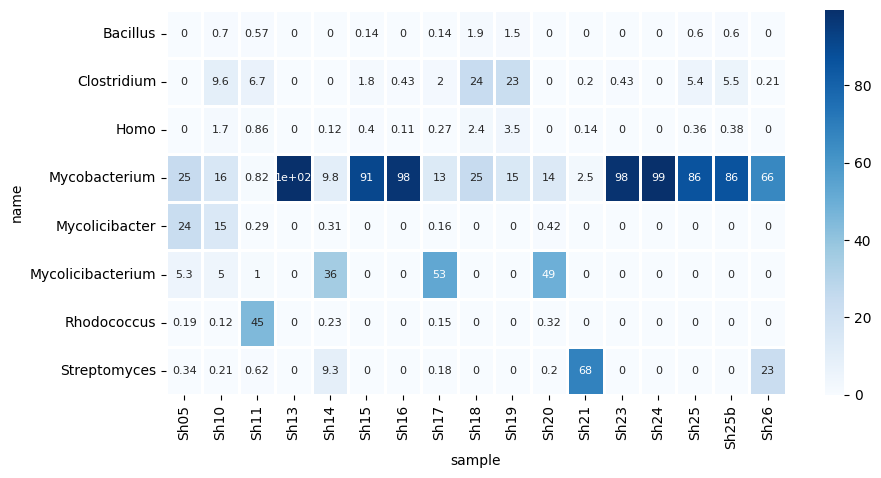

In [15]:
found = pd.read_csv('contam_standard16.csv')
found = found[found.run.isin([3,4])]
x=found[found.rank_code=='G']
contam = x.pivot_table(index='sample',columns='name',values='perc_frag').fillna(0).T
contam = contam[contam.sum(1)>3]
ax=plt.subplots(1,1,figsize=(10,5))
sns.heatmap(contam,lw=1,cmap='Blues',annot=True,yticklabels=True,annot_kws={'fontsize':8})
plt.savefig('kraken.png',dpi=150)

## SRA ethopia 

In [ ]:
df = pd.read_csv('ethiopia_sra.csv')
reload(tools)
tools.fetch_sra_reads(df, 'sra', key='Accession', sample_size=20, omit=['ERR4772237','ERR4772234']) # test=True

## mycolicbacter

In [ ]:
out='mycolicibacter/annot'
files = glob.glob('mycolicibacter/data/*.fa')

for f in files:    
    name = os.path.splitext(os.path.basename(f))[0]    
    cmd = '/local/prokka/bin/prokka --genus mycolicibacter --outdir {o}/{n} {f} --prefix {n}'.format(f=f,n=name,o=out)
    if not os.path.exists('%s/%s' %(out,name)):
        print (cmd)
        subprocess.check_output(cmd, shell=True)

In [24]:
files = glob.glob('mycolicibacter/annot/**/*.faa',recursive=True)
for f in files:
    shutil.copy(f, os.path.join('mycolicibacter/faa',os.path.basename(f)))

## Orthofinder

In [66]:
#extract ncbi dataset files

ncbi = pd.read_csv('mycolicibacter/ncbi_dataset.tsv',sep='\t')
x=ncbi.drop_duplicates(subset=['Organism Name'])
names = list(x['Assembly Accession'])

files = glob.glob('mycolicibacter/ncbi_data/*',recursive=True)

for f in files:
    name = os.path.basename(f)
    if name not in names: continue  
    #prot = os.path.join(f, 'protein.faa')
    #target = os.path.join('mycolicibacter/faa',name+'.faa')    
    nuc = os.path.join(f, 'protein.faa')
    #print (f,name,prot, target)   
    try:
        shutil.copy(prot, target)
    except:
        pass

In [68]:
indir = 'faa'
cmd = f'python3 /local/OrthoFinder_source/orthofinder.py -t 12 -f {indir}'
print (cmd)

python3 /local/OrthoFinder_source/orthofinder.py -t 12 -f faa


## blast contigs against species locally

In [8]:
#tools.make_blast_database('mycolicibacter/all_species.fa')
bl=tools.blast_fasta('mycolicibacter/all_species.fa','mycolicibacter/Sh17.fa')

In [54]:
bl['species'] = bl.stitle.apply(lambda x: x.split(' ')[1:3])

In [55]:
x=bl[bl.pident>95]
cols = ['qseqid','sseqid','pident','qcovs','length','species']
#x.sseqid.value_counts()
x = x.groupby('qseqid').first()[cols[1:]]

In [ ]:
xx=x.sort_values('length',ascending=False)[:30]
xx.plot(x='species',y='pident',kind='barh',figsize=(4,8))

## get assemblies for nocardia farcinica

In [ ]:
reload(entrez)
#ids = entrez.find_assemblies('Nocardia Farcinica')
df=pd.read_csv('uilist.txt')
ids = list(df.id)
res = entrez.get_assembly_report(ids)

res.to_csv('assembly_report.csv')

In [12]:
#entrez.download_links(res,'entrez_assemblies')
def func(x):
    return re.sub(r'\.(1|2)', '', x)
res['name'] = res.GenbankAccession.apply(func,1)
res['country'] = res.geo_loc_name.fillna('').apply(lambda x: x.split(':')[0])
res=res.drop_duplicates('name')
res=res.set_index('name')

/tmp/ipykernel_3730162/583507303.py:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  res['name'] = res.GenbankAccession.apply(func,1)


In [14]:
res.to_csv('assembly_report.csv')

In [118]:
## samtools filter reads for contamination plugin...

bamfile = 'melese_results/contam/a004~~LT708304.1.bam'
bamfile = 'melese_results/contam/a004~~NC_006361.1.bam'
out = 'test.bam'

for q in [1,5,60,61]:
    #cmd = 'samtools view -e \'[NM]<={m}\' -O BAM -o {o} {i}'.format(i=bamfile,o=out,m=mm)
    cmd = 'samtools view -q {q} -O BAM -o {o} {i}'.format(i=bamfile,o=out,q=q)   
    #print (cmd)
    subprocess.check_output(cmd,shell=True)
    d = tools.samtools_flagstat(out)
    print (q,d['total'])

1 66768
5 66731
60 63589
61 0
